# GBDT Training Code Testbed

This notebook will conduct code prototyping for executing GBDT training related processes.

# Libraries and Aux. Methods

In [1]:
#Python Libraries
import time
from datetime import datetime

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import LearningCurveDisplay

#GBDT Models
import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

#Timer
start = end = 0
def startTime():
    global start
    start = time.time()
def endTime():
    global start
    elapse = time.time()-start
    start = 0
    print(f"Elapsed Time: {round(elapse, 6)}s\n")
    return round(elapse, 6)

#File paths
TB = "../Dataset/TB/TB.csv"
TB_Reserve = "../Dataset/TB/TB_Reserve.csv"
TB_Enc = "../Dataset/TB/TB_Enc.csv"
TB_Reserve_Enc = "../Dataset/TB/TB_Reserve_Enc.csv"
IB = "../Dataset/IB/IB.csv"
IB_Reserve = "../Dataset/IB/IB_Reserve.csv"
IB_Enc = "../Dataset/IB/IB_Enc.csv"
IB_Reserve_Enc = "../Dataset/IB/IB_Reserve_Enc.csv" 

#Best parameters
best_param_file = f"Best_Params_{str(datetime.now()).replace(':','-').replace(' ','_')}.txt"

#N_Split
SPLIT = 3 #33.33% test ratio; Test ratio can be computed as ratio=1/SPLIT

In [2]:
#DATASET PARSING
tb = pd.read_csv(TB, low_memory=False)
tb_res = pd.read_csv(TB_Reserve, low_memory=False)
tb_enc = pd.read_csv(TB_Enc, low_memory=False)
tb_res_enc = pd.read_csv(TB_Reserve_Enc, low_memory=False)

ib = pd.read_csv(IB, low_memory=False)
ib_res = pd.read_csv(IB_Reserve, low_memory=False)
ib_enc = pd.read_csv(IB_Enc, low_memory=False)
ib_res_enc = pd.read_csv(IB_Reserve_Enc, low_memory=False)

In [3]:
#AUXILIARY FUNCTIONS
#Separate the features (X) & labels (y)
def getXy(dataset):
    return dataset.iloc[:,1:],dataset.iloc[:,0]

#Generate StratifiedKFold object at given splits
def getStratKFold(splits):
    #It might be shuffled but it does so consistently (i.e., random_state=1)
    return StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)

def getSplit(X,y):
    return train_test_split(X, y, test_size=.30, random_state=1, shuffle=True)

#Internal K-Folds Test (for in-training testing)
def kfolds_test(X,y,model):
    print("Internal KFolds Test")
    sublist = [["accuracy", "f1_score","precision","recall","roc-auc","time(s)"]]
    axis = 0
    for i, (train_index, test_index) in enumerate(getStratKFold(SPLIT).split(X,y)):
        start = time.time()
        test_set = np.take(X, test_index, axis)
        test_set_labels = np.take(y, test_index, axis)
        m_pred = model.predict(test_set)
        sublist.append([
                        round(accuracy_score(test_set_labels, m_pred),4),
                        round(f1_score(test_set_labels, m_pred, average='weighted'),4),
                        round(precision_score(test_set_labels, m_pred),4),
                        round(recall_score(test_set_labels, m_pred),4),
                        round(roc_auc_score(test_set_labels, m_pred),4),
                        round(time.time()-start,4)
                        ])
    for s in sublist:
        print(s)
    print("")

#Learning Curves
def learning_curve(dataset,model):
    X,y = getXy(dataset)
    vis_param = {
    "X": X, "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 20),
    "cv": getStratKFold(SPLIT),
    "score_type": "both", "n_jobs": 1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "accuracy",
    }
    display = LearningCurveDisplay.from_estimator(model, **vis_param)
    plt.show()
    
#K-folds sample visualization
def kfolds_vis(dataset):
    X,y = getXy(dataset)
    fig, ax = plt.subplots(figsize=(10,SPLIT+1))
    train = plot_cv_indices(getStratKFold(SPLIT), X, y, ax, SPLIT)
    plt.show()

#K-folds sample visualization (inner workings)
def plot_cv_indices(cv, X, y, ax, n_splits, lw=25):
    #From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        ax.scatter(range(len(indices)), [ii] * len(indices), c=indices, marker="_", 
                   lw=lw, cmap=plt.cm.Paired, vmin=0, vmax=1)
    #ax.scatter(range(len(X)), [ii] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired)
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels, xlabel="Dataset Subsample", ylabel="CV iteration", ylim=[n_splits,-1], xlim=[0, X.shape[0]])
    ax.set_title("{}".format(type(cv).__name__))
    return ax

# Data Distribution at Stratified K-Folds

Stratified K-Folds Split at 3 splits.
TB/TB_Encoded Dataset


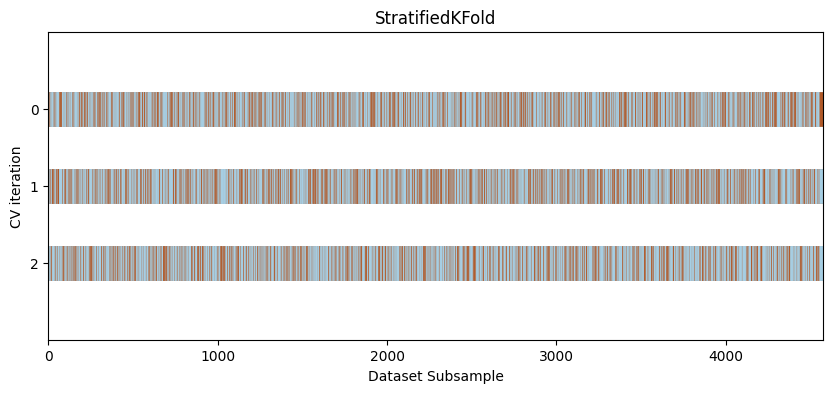

IB/IB_Encoded Dataset


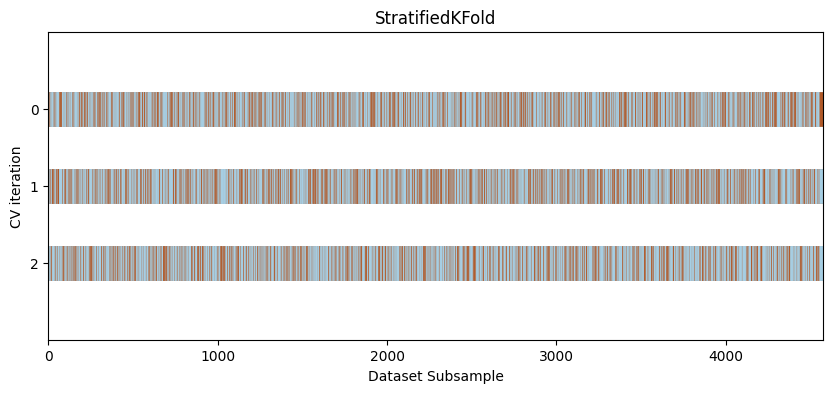

In [4]:
print("Stratified K-Folds Split at",SPLIT,"splits.")
print("TB/TB_Encoded Dataset")
kfolds_vis(tb_enc)
print("IB/IB_Encoded Dataset")
kfolds_vis(ib_enc)

# Learning Curves (Default Models)

In [ ]:
print("Learning Curves for LightGBM Default")
print("via TB_Enc")
learning_curve(tb_enc, lightgbm.LGBMClassifier(n_jobs=-1, random_state=1, verbose=-1))
print("via IB_Enc")
learning_curve(ib_enc, lightgbm.LGBMClassifier(n_jobs=-1, random_state=1, verbose=-1))

Learning Curves for LightGBM Default
via TB_Enc


In [ ]:
print("Learning Curves for CatBoost Default")
print("via TB_Enc")
learning_curve(tb_enc, catboost.CatBoostClassifier(thread_count=-1, random_state=1, verbose=0))
print("via IB_Enc")
learning_curve(ib_enc, catboost.CatBoostClassifier(thread_count=-1, random_state=1, verbose=0))

# Preparing Training Functions

In [ ]:
#Model training; Shows a simple k-folds test
def train_model(model, dataset, title): #model assumes to be either trained/fitted or not
    X,y = getXy(dataset) #Get features(X) and labels(y)
    X_train, X_test, y_train, y_test = getSplit(X, y)#Splitting data into train (70%) and test (30%) 
    print("Training", title, "...")
    start = time.time()
    model.fit(X_train, y_train) #Training
    print(f"{title} Training Time: {time.time()-start:.4f}s")
    print(title, "Trained!")
    print("Internal Classification Report:\n", classification_report(y_test, model.predict(X_test),digits=4))
    kfolds_test(X_test, y_test, model) #Check current capabilities using entirety of Train Split ("Training"+"Validation"; i.e., mix of know and unknown)
    return model

def tune_model(model, params, dataset, title):
    X,y = getXy(dataset) #Get features(X) and labels(y)
    print("Tuning", title, "...")
    #Example shown uses RandomizedSearchCV
    #n_iter ideally should be >=10, but for the sake of testing it was set to 5
    tuner = RandomizedSearchCV(model, params, n_iter=5, scoring='accuracy', n_jobs=1, 
                               refit=True, cv=getStratKFold(SPLIT), verbose=2, pre_dispatch='2*n_jobs', random_state=1, 
                               error_score=0, return_train_score=False)
    start = time.time()
    tuner.fit(X,y) #Utilizing Train Split (i.e., both "Training"+"Validation") for tuning as it uses its own CV method
    print(f"{title} Tuning Time: {time.time()-start:.4f}s")
    print(title, "Tuned!")
    print(title, "Best Params:", tuner.best_params_)
    return tuner.best_params_

def saveLGBM(model, filename):
    if ".joblib" not in filename:
        filename += ".joblib"
    dump(model, filename)
    print("LGBM Model", filename, "saved!")

def saveCatB(model, filename):
    if ".json" not in filename:
        filename += ".json"
    model.save_model(filename, format="json")
    print("CatBoost Model", filename, "saved!")

def lbgm_train_tune(dataset, title, lgbm_params):
    #Default
    lgbm_classifier = lightgbm.LGBMClassifier(random_state=1, n_jobs=-1, verbose=-1)
    lgbm_default = train_model(lgbm_classifier, dataset, title+"_Default")
    saveLGBM(lgbm_default, title+"_Default.joblib")
    #Tuning
    lgbm_params = tune_model(lgbm_classifier, lgbm_params, dataset, title+"_Tuned")
    #Tuned
    lgbm_classifier = lightgbm.LGBMClassifier(**lgbm_params, random_state=1, n_jobs=-1, verbose=-1)
    lgbm_tuned = train_model(lgbm_classifier, dataset, title+"_Tuned")
    saveLGBM(lgbm_tuned, title+"_Tuned.joblib")
    return lgbm_default, lgbm_tuned
    
def catb_train_tune(dataset, title, catb_params):
    indexes = []
    for i in range(dataset.shape[1]-1):
        indexes.append(i)
    #Default
    catb_classifier = catboost.CatBoostClassifier(random_state=1, thread_count=-1, verbose=0, cat_features=indexes, nan_mode='Min')
    catboost_default = train_model(catb_classifier, dataset, title+"_Default")
    saveCatB(catboost_default, title+"_Default.json")
    #Tuning
    catb_params = tune_model(catb_classifier, catb_params, dataset, title+"_Tuned")
    #Tuned
    catb_classifier = catboost.CatBoostClassifier(**catb_params, random_state=1, thread_count=-1, verbose=0, cat_features=indexes, nan_mode='Min')
    catboost_tuned = train_model(catb_classifier, dataset, title+"_Tuned")
    saveCatB(catboost_tuned, title+"_Tuned.json")
    return catboost_default, catboost_tuned

# LightGBM Models

In [ ]:
#Sample (tested) parameter set
lgbm_params = {
    #Common
    'boosting_type':['gbdt'], 
    'max_depth':[-1], 
    'learning_rate':[0.1], 
    'n_estimators':[50], #Limited to 50 for prototyping; [100,250,500,750,1000]
    'l2_leaf_reg':[1,2,3,4,5],
    'class_weight': ['balanced'], #Specify that classes are weighted equally (i.e., no inherent bias)
    'device':['cpu'], #cpu/gpu (CUDA/OpenCL)
    'boost_from_average':[True, False],
    'num_leaves':[2,4,8,16,31,32,64],
    
    #LGBM specific
    'objective':['binary'], #Specify that model is for binary classification; same as metric:binary_logloss
    'data_sample_strategy':['goss'], #goss/bagging
    'tree_learner':['data'], #For parallel computing
}

#lgbm_params = tune_model(lightgbm.LGBMClassifier(random_state=1, n_jobs=-1, verbose=0), lgbm_params, tb_enc, "test"+"_Tuned")

In [ ]:
#Time-based LGBM
default, tuned = lbgm_train_tune(tb_enc, "TB_LGBM", lgbm_params)

lgbm_tb_tuned_param = tuned.get_params()
print(f"lgbm_tb_tuned_param\n{lgbm_tb_tuned_param}\n", file=open(best_param_file, mode='a'))

In [ ]:
#Instance-based LGBM
default, tuned = lbgm_train_tune(ib_enc, "IB_LGBM", lgbm_params)

lgbm_ib_tuned_param = tuned.get_params()
print(f"lgbm_ib_tuned_param\n{lgbm_ib_tuned_param}\n", file=open(best_param_file, mode='a'))

# CatBoost Models

In [ ]:
#Sample (tested) parameter set
catb_params = {
    #Common
    'boosting_type':['Ordered'], #As per paper "Ordered Boosting"
    'max_depth':[6,11,16], #As per documentation: min=6, max=16, mean=(max-min)/2
    'learning_rate':[0.1], #Typical learning rate (either 0.1 or 0.3)
    'n_estimators':[50], #Limited to 50 for prototyping; [100,250,500,750,1000]
    'l2_leaf_reg':[1,2,3,4,5], #CatB default=3
    'auto_class_weights':['Balanced'], #Specify that classes are weighted equally (i.e., no inherent bias)
    'task_type':['CPU'], #CPU/GPU (CUDA)
    'boost_from_average':[True, False],
    #'num_leaves':[2,4,8,16,31,32,64], #Only works with Lossguide grow_policy which is not compatible with "Ordered Boosting"
    
    #CatBoost specific
    'grow_policy':['SymmetricTree'], #Lossguide not possible due to boosting type being ordered
    'objective':['Logloss'], #To be same as what's used in Binary LightGBMClassifier
    'bootstrap_type':['Bayesian'] #Recommended for classifier models
}


#indexes = []
#for i in range(tb.shape[1]-1):
#    indexes.append(i)
#catb_classifier = catboost.CatBoostClassifier(random_state=1, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min')
#catb_params = tune_model(catb_classifier, catb_params, tb, "catboost_test"+"_Tuned")

In [ ]:
#Time-based CatBoost
default, tuned = catb_train_tune(tb, "TB_CATB", catb_params)

catb_tb_tuned_param = tuned.get_param()
print(f"catb_tb_tuned_param\n{catb_tb_tuned_param}\n", file=open(best_param_file, mode='a'))

In [ ]:
#Instance-based CatBoost
default, tuned = catb_train_tune(ib, "IB_CATB", catb_params)

catb_ib_tuned_param = tuned.get_param()
print(f"catb_ib_tuned_param\n{catb_ib_tuned_param}\n", file=open(best_param_file, mode='a'))

# Learning Curve (Tuned Models)

In [ ]:
print("Learning Curves for LightGBM Default")
print("via TB_Enc")
learning_curve(tb_enc, lightgbm.LGBMClassifier(**lgbm_tb_tuned_param))
print("via IB_Enc")
learning_curve(ib_enc, lightgbm.LGBMClassifier(**lgbm_ib_tuned_param))

In [ ]:
print("Learning Curves for CatBoost Default")
print("via TB_Enc")
learning_curve(tb_enc, catboost.CatBoostClassifier(**catb_tb_tuned_param))
print("via IB_Enc")
learning_curve(ib_enc, catboost.CatBoostClassifier(**catb_ib_tuned_param))